In [1]:
# Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
import wget

wget.download('https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')
# !wget --no-check-certificate \
#     https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
#     -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [2]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

local_weights_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape=(150, 150, 3),
                                include_top=False,
                                weights=None)

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

In [4]:
# Block the model to train
for layer in pre_trained_model.layers:
    layer.trainable = False

In [5]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [6]:
# Choose `mixed_7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


# Add dense layers for your classifier

Next, you will add dense layers to your model. These will be the layers that you will train and is tasked with recognizing cats and dogs. You will add a Dropout layer as well to regularize the output and avoid overfitting.



In [20]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=pre_trained_model.input, outputs=x)

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=1e-4), metrics=['accuracy'])


# Prepare the dataset

In [9]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define our example directories and files
base_dir = 'cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1. / 255.,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1.0 / 255.)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        batch_size=20,
                                                        class_mode='binary',
                                                        target_size=(150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [21]:
history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=20,
                    validation_data=validation_generator,
                    validation_steps=50,
                    verbose=1)

Epoch 1/20
100/100 [==============================] - 11s 92ms/step - loss: 0.3560 - accuracy: 0.8610 - val_loss: 0.0946 - val_accuracy: 0.9590
Epoch 2/20
100/100 [==============================] - 8s 81ms/step - loss: 0.2122 - accuracy: 0.9195 - val_loss: 0.1539 - val_accuracy: 0.9460
Epoch 3/20
100/100 [==============================] - 9s 95ms/step - loss: 0.1886 - accuracy: 0.9280 - val_loss: 0.1049 - val_accuracy: 0.9610
Epoch 4/20
100/100 [==============================] - 9s 93ms/step - loss: 0.2202 - accuracy: 0.9160 - val_loss: 0.1599 - val_accuracy: 0.9490
Epoch 5/20
100/100 [==============================] - 9s 87ms/step - loss: 0.1930 - accuracy: 0.9305 - val_loss: 0.1061 - val_accuracy: 0.9660
Epoch 6/20
100/100 [==============================] - 9s 85ms/step - loss: 0.1915 - accuracy: 0.9330 - val_loss: 0.1409 - val_accuracy: 0.9580
Epoch 7/20
100/100 [==============================] - 8s 84ms/step - loss: 0.1548 - accuracy: 0.9440 - val_loss: 0.1099 - val_accuracy: 0.966

# Evaluate the results

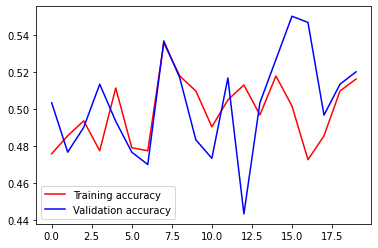

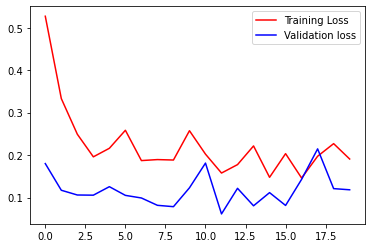

In [18]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.legend(loc=0)

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.legend(loc=1)
plt.show()